<h1 style = "font-family: garamond; font-size: 50px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :royalblue; border-radius: 100px 100px; text-align:center " >Evaluation of Movie Plot Summarization Methods</h1>
<h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :royalblue; border-radius: 100px 100px; text-align:center " >Training and Modeling</h1>

<h1 style = "font-family: garamond; font-size: 45px; font-style: normal; letter-spacing: 3px; background-color: #f6f5f5; color :royalblue; border-radius: 100px 100px; text-align:center " >Table of Contents</h1>


* [1. Data Loading](#1)
* [2. Introduction](#2)
* [3. Extractive Summarization](#3)
    * [3.1 Spacy](#3.1)
    * [3.2 Sumy LSA](#3.2)
    * [3.3 Sumy Luhn](#3.3)
* [4. Abstractive Summarization](#4)
    * [4.1 Walkthrough of Encoder-Decoder Seq2Seq model](#4.1)
    * [4.2 T5](#4.2)
    * [4.3 Bart](#4.3)
* [5. Results](#5)
    * [5.1 Subjective measures](#5.1)
    * [5.2 Objective measures](#5.2)
* [6. Summary](#6)

In [552]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
import ast
import statistics

<a id = '1'></a>
<h3 style = "font-family:garamond; font-size:35px; background-color: white; color : royalblue; border-radius: 100px 100px; text-align:left">Data Loading</h3>

In [2]:
df = pd.read_csv('../data/df_final.csv')

In [3]:
df

,Release Year,Title,Plot,Overview,cleaned_plot,cleaned_overview
0,1902,Jack and the Beanstalk,The earliest known adaptation of the classic f...,Abbott and Costello's version of the famous fa...,the earliest known adaptation of the classic f...,sostok _START_ abbott and costello version of ...
1,1905,The Night Before Christmas,Scenes are introduced using lines of the poem....,A cartoon based on the works of Nikolay Gogol....,scenes are introduced using lines of the poem ...,sostok _START_ a cartoon based on the works of...
2,1906,Dream of a Rarebit Fiend,The Rarebit Fiend gorges on Welsh rarebit at a...,Adapted from Winsor McCay's films and comics o...,the rarebit fiend gorges on welsh rarebit at r...,sostok _START_ adapted from winsor mccay films...
3,1908,A Christmas Carol,No prints of the first American film adaptatio...,Reginald Owen portrays Charles Dickens' holida...,no prints of the first american film adaptatio...,sostok _START_ reginald owen portrays charles ...
4,1910,Ramona,Ramona chronicles the romance between Ramona (...,Half-Indian girl brought up in a wealthy house...,ramona chronicles the romance between ramona m...,sostok _START_ half-indian girl brought up in ...
...,...,...,...,...,...,...
3022,2016,The Age of Shadows,A Korean police captain named Lee Jung-chool (...,Movie follows the activities of the Heroic Cor...,a korean police captain named lee jung-chool s...,sostok _START_ movie follows the activities of...
3023,2016,My Annoying Brother,National Judo athlete Doo-young (Do Kyung-soo)...,Doo-Sik (Jo Jung-suk) gets paroled from prison...,national judo athlete doo-young do kyung-soo d...,sostok _START_ doo-sik jo jung-suk gets parole...
3024,2017,Fabricated City,"In real life, Kwon Yoo (Ji Chang-wook) is unem...","In real life, Kwon Yoo is unemployed, but in t...",in real life kwon yoo ji chang-wook is unemplo...,sostok _START_ in real life kwon yoo is unempl...
3025,2017,New Trial,The film tells the story of a man whose life w...,"A taxi driver is found dead, and Hyun-woo, the...",the film tells the story of man whose life was...,sostok _START_ a taxi driver is found dead and...


Youtube video on extractive summarization

- Text cleaning
- Sentence Tokenization
- Word Tokenization
- Word-frequency table
- Summarization

<a id = '2'></a>
<h3 style = "font-family:garamond; font-size:35px; background-color: white; color : royalblue; border-radius: 100px 100px; text-align:left">Introduction to Text Summarization</h3>

- Text summarization is the method of extracting summaries from original text without losing any vital information. It has many applications and, much like NLP in general, has seen much improvement over the past few years. In this notebook, we will use our cleaned movie dataset to explore the more common approaches to text summarization and compare which is best. We will use some objective criteria like cosine similarity scores and rouge scores to compare the various methods, but at the time of this writing, nothing evaluates the results of summarization better than humans. Thus, we cannot avoid invoking our own subjective and flawed evaluations.

- The first thing to know is that text summarization methods can be grouped into two categories: Extractive and Abstractive methods.
- Extractive summarization seeks to identify the most significant sentences of the text and use them to create a summary. Thus, the summary contains the exact sentences from the original text.
- Abstractive summarization seeks to identify the important sections and interpret the context in order to generate sentences for the summary. This method is far more advanced and has much more room for improvement over extractive methods. 

<a id = '3'></a>
<h3 style = "font-family:garamond; font-size:35px; background-color: white; color : royalblue; border-radius: 100px 100px; text-align:left">Extractive Models</h3>

To save time we are going to use a selection of 10 movies to compare the generated summaries from

In [4]:
df_10 = df.loc[(df['Overview'].str.split().str.len() <= 30) & (df['Release Year'] >= 1980)].sample(n=10)
df_10 = df_10.reset_index(drop=True)
df_10

,Release Year,Title,Plot,Overview,cleaned_plot,cleaned_overview
0,1995,The Basketball Diaries,The film is an adaptation of poet and memoiris...,Film adaptation of street tough Jim Carroll's ...,the film is an adaptation of poet and memoiris...,sostok _START_ film adaptation of street tough...
1,2007,Full of It,Sam Leonard is the new kid at Bridgeport High ...,A young kid (Pinkston) is forced to live out t...,sam leonard is the new kid at bridgeport high ...,sostok _START_ a young kid pinkston is forced ...
2,1999,Cradle Will Rock,"At the height of the Great Depression, aspirin...",A true story of politics and art in the 1930s ...,at the height of the great depression aspiring...,sostok _START_ a true story of politics and ar...
3,1996,True Blue,True Blue is a film adaptation of Topolski's b...,The story of the year the Oxford and Cambridge...,true blue is film adaptation of topolski book ...,sostok _START_ the story of the year the oxfor...
4,1984,Gimme an 'F',The plot centers on a competition between high...,Can a squad of misfit cheerleaders with an ove...,the plot centers on competition between high-s...,sostok _START_ can squad of misfit cheerleader...
5,2007,Brooklyn Rules,"In 1985 Michael (Freddie Prinze Jr.), the narr...","Brooklyn, 1985. With the mob world as a backdr...",in 1985 michael freddie prinze jr the narrator...,sostok _START_ brooklyn 1985 with the mob worl...
6,1986,King Kong Lives,"King Kong, after being shot down from the Worl...",Kong falls from the twin towers and he appears...,king kong after being shot down from the world...,sostok _START_ kong falls from the twin towers...
7,1993,Mr. Jones,Mr. Jones (Richard Gere) is a man suffering fr...,The story about the relationship between a man...,mr jones richard gere is man suffering from bi...,sostok _START_ the story about the relationshi...
8,2000,Hanging Up,"Georgia Mozell, Eve Marks and Maddy Mozell are...",A trio of sisters bond over their ambivalence ...,georgia mozell eve marks and maddy mozell are ...,sostok _START_ a trio of sisters bond over the...
9,2013,Black Butterfly,The story of Black Butterfly focuses on how ce...,A Peruvian schoolteacher conspires with a jour...,the story of black butterfly focuses on how ce...,sostok _START_ a peruvian schoolteacher conspi...


<a id = '3.1'></a>
<h3 style = "font-family:garamond; font-size:30px; background-color: white; color : royalblue; border-radius: 100px 100px; text-align:left">SpaCy</h3>

spaCy is a free, open-source natural language processing library. It provide a fast and accurate syntactic analysis, named entity recognition and ready access to word vectors. It also offers tokenization, sentence boundary detection, POS tagging, syntactic parsing, integrated word vectors, and alignment into the original string with high accuracy. 

Import the modules

In [5]:
'''!python -m spacy download en_core_web_sm'''
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from collections import Counter
from heapq import nlargest

Load the English model into spaCy

In [6]:
nlp = spacy.load('en_core_web_sm')

We will come back to our 10 movies. For now we will demonstrate this process on 1 random film

In [8]:
single_samp = df.sample()
single_samp = single_samp.reset_index()
single_samp

,Release Year,Title,Plot,Overview,cleaned_plot,cleaned_overview
2485,1993,The Secret Adventures of Tom Thumb,The story follows the tiny Tom Thumb as he is ...,A boy born the size of a small doll is kidnapp...,the story follows the tiny tom thumb as he is ...,sostok _START_ a boy born the size of small do...


We take the plot only and pass the string into the nlp function

In [9]:
doc = single_samp['Plot']
doc = doc.iloc[0]['Plot']
doc = nlp(doc)

Filtering Tokens: We need to create 2 lists for parts-of-speech and stop words to validate each token followed by filtering of the necessary tokens and saving them in the keywords list. 

In [10]:
keyword = []
stopwords = list(STOP_WORDS)
pos_tag = ['PROPN', 'ADJ', 'NOUN', 'VERB']
for token in doc:
    if(token.text in stopwords or token.text in punctuation):
        continue
    if(token.pos_ in pos_tag):
        keyword.append(token.text)

Next lets calculate the frequency of each token

In [11]:
freq_word = Counter(keyword)

Normalization of the list

In [12]:
max_freq = Counter(keyword).most_common(1)[0][1]
for word in freq_word.keys():  
    freq_word[word] = (freq_word[word]/max_freq)

We can see what this list should look like

In [13]:
freq_word.most_common(5)

[('parents', 1.0),
 ('story', 0.5),
 ('follows', 0.5),
 ('tiny', 0.5),
 ('Tom', 0.5)]

Weighing sentences: Each sentence will be weighed based on the frequency of the token present in each sentence. sent_strength is a python dictionary where the keys are the sentences and the string doc and the values are the weight of each sentence.

In [14]:
sent_strength={}
for sent in doc.sents:
    for word in sent:
        if word.text in freq_word.keys():
            if sent in sent_strength.keys():
                sent_strength[sent]+=freq_word[word.text]
            else:
                sent_strength[sent]=freq_word[word.text]

We can see what this looks like

In [15]:
sent_strength

{The story follows the tiny Tom Thumb as he is abducted from his loving parents and taken to an experimental laboratory, and his subsequent escape.: 7.0,
 He discovers a community of similarly-sized people living in a swamp, who help him on his journey to return to his parents.: 5.5,
 The film is largely dialogue-free, limited mostly to grunts and other non-verbal vocalizations.: 4.0}

Lastly, nlargest is used to summarize the string with 3 arguments: number of sentences to extract (we will do 5 sentences here); the list/tuple/dictionary to iterate over; the condition that needs to be satisfied. The resulting summarized_sentences is a list of sentences of spaCy.span type, which will be converted to a string. 

In [16]:
summarized_sentences = nlargest(8, sent_strength, key=sent_strength.get)
final_sentences = [ w.text for w in summarized_sentences ]
summary = ' '.join(final_sentences)
print(summary)

The story follows the tiny Tom Thumb as he is abducted from his loving parents and taken to an experimental laboratory, and his subsequent escape. He discovers a community of similarly-sized people living in a swamp, who help him on his journey to return to his parents. The film is largely dialogue-free, limited mostly to grunts and other non-verbal vocalizations.


Now, back to our 10 random movies to use for comparison. Let's take everything we just did and make it into a function that we can use in a for loop for our 10 random movies dataframe.

In [17]:
def spacy_extract(df_plot):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(df_plot)
    keyword = []
    stopwords = list(STOP_WORDS)
    pos_tag = ['PROPN', 'ADJ', 'NOUN', 'VERB']
    for token in doc:
        if(token.text in stopwords or token.text in punctuation):
            continue
        if(token.pos_ in pos_tag):
            keyword.append(token.text)
    freq_word = Counter(keyword)
    max_freq = Counter(keyword).most_common(1)[0][1]
    for word in freq_word.keys():  
        freq_word[word] = (freq_word[word]/max_freq)
    sent_strength={}
    for sent in doc.sents:
        for word in sent:
            if word.text in freq_word.keys():
                if sent in sent_strength.keys():
                    sent_strength[sent]+=freq_word[word.text]
                else:
                    sent_strength[sent]=freq_word[word.text]
    summarized_sentences = nlargest(3, sent_strength, key=sent_strength.get)
    final_sentences = [ w.text for w in summarized_sentences ]
    summary = ' '.join(final_sentences)
    return summary

In [18]:
spacy_generated_overview = []
for i in df_10['Plot']:
    spacy_generated_overview.append(spacy_extract(i))

In [19]:
for i in spacy_generated_overview:
    print('Generated Overview: ', i, '\n')

Generated Overview:  Bobby (Michael Imperioli), a best friend who is dying of leukemia; a coach ("Swifty", played by Bruno Kirby) who makes sexual advances to Jim; and an appetite for cocaine and heroin begin to encroach on young Jim's dream of becoming a basketball star. As a member of a seemingly unbeatable high school basketball squad, Jim's life centers on his friends and the basketball court; the court becomes a metaphor for the world in his mind. The film is an adaptation of poet and memoirist Jim Carroll's juvenile diaries chronicling his kaleidoscopic free-fall into the harrowing world of drug addiction. 

Generated Overview:  Sam tells lies like "I drive a Porsche", "My dad's a rock star", "My dog ate my homework", "I never miss a shot" (at basketball) and that Vicki Sanders and his English teacher Mrs. Moran are lusting after him. The next morning, Sam finds his dog actually eating his homework, he has a Porsche, he never misses a shot, and Mrs. Moran and Vicki Sanders are af

<a id = '3.2'></a>
<h3 style = "font-family:garamond; font-size:30px; background-color: white; color : royalblue; border-radius: 100px 100px; text-align:left">From sumy library</h3>

The sumy library is much easier to use. We simply parse and tokenize the text and feed it into our summarizers. There are quite a few techiniques in the sumy library, but shall explore two, LSA and Luhn. 

In [181]:
from sumy.nlp.tokenizers import Tokenizer
from sumy.parsers.plaintext import PlaintextParser

<a id = '3.2'></a>
<h3 style = "font-family:garamond; font-size:30px; background-color: white; color : royalblue; border-radius: 100px 100px; text-align:left">LSA</h3>

LSA, or latent semantic analysis, is one of the more recent extractive summarization techniques. It is an unsupervised method that combines term frequency techniques with SVD (singular value decomposition). 

In [180]:
from sumy.summarizers.lsa import LsaSummarizer

initialize the parser

In [197]:
parser=PlaintextParser.from_string(single_samp.iloc[0]['Plot'],Tokenizer('english'))

We will choose 6 sentences

In [193]:
lsa_summarizer = LsaSummarizer()
lsa_summary = lsa_summarizer(parser.document,6)
for sentence in lsa_summary:
 print(sentence)

The story follows the tiny Tom Thumb as he is abducted from his loving parents and taken to an experimental laboratory, and his subsequent escape.
He discovers a community of similarly-sized people living in a swamp, who help him on his journey to return to his parents.
The film is largely dialogue-free, limited mostly to grunts and other non-verbal vocalizations.


Now let's run this on our 10 movies for comparison

In [195]:
sumy_lsa_generated_overview = []
for i in df_10['Plot']:
    parser=PlaintextParser.from_string(i, Tokenizer('english'))
    lsa_summarizer = LsaSummarizer()
    lsa_summary = lsa_summarizer(parser.document, sentences_count=6)
    gen_sum = ''
    for sen in lsa_summary:
        gen_sum = gen_sum + str(sen) + ' '
    sumy_lsa_generated_overview.append(gen_sum)

<a id = '3.3'></a>
<h3 style = "font-family:garamond; font-size:30px; background-color: white; color : royalblue; border-radius: 100px 100px; text-align:left">Luhn</h3>

This one is based on TF-IDF. It scores sentences based on frequency of the most important words.

In [21]:
from sumy.summarizers.luhn import LuhnSummarizer

Initialize the parser

In [198]:
parser=PlaintextParser.from_string(single_samp.iloc[0]['Plot'],Tokenizer('english'))

instantiate the summarizer with the text document and choose the number of sentences

In [199]:
luhn_summarizer=LuhnSummarizer()
luhn_summary=luhn_summarizer(parser.document,sentences_count=6)

In [201]:
for sentence in luhn_summary:
 print(sentence)

The story follows the tiny Tom Thumb as he is abducted from his loving parents and taken to an experimental laboratory, and his subsequent escape.
He discovers a community of similarly-sized people living in a swamp, who help him on his journey to return to his parents.
The film is largely dialogue-free, limited mostly to grunts and other non-verbal vocalizations.


Now let's run this on our 10 movies

In [25]:
sumy_luhn_generated_overview = []
for i in df_10['Plot']:
    parser=PlaintextParser.from_string(i, Tokenizer('english'))
    luhn_summarizer = LuhnSummarizer()
    luhn_summary = luhn_summarizer(parser.document, sentences_count=6)
    gen_sum = ''
    for sen in luhn_summary:
        gen_sum = gen_sum + str(sen) + ' '
    sumy_luhn_generated_overview.append(gen_sum)

In [26]:
for i in sumy_luhn_generated_overview:
    print('Generated Overview: ', i, '\n')

Generated Overview:  As a member of a seemingly unbeatable high school basketball squad, Jim's life centers on his friends and the basketball court; the court becomes a metaphor for the world in his mind. Bobby (Michael Imperioli), a best friend who is dying of leukemia; a coach ("Swifty", played by Bruno Kirby) who makes sexual advances to Jim; and an appetite for cocaine and heroin begin to encroach on young Jim's dream of becoming a basketball star. After Jim is suspended from school due to playing a basketball game while under the influence of drugs, he drops out. The only escape that Jim has from the reality of the streets is heroin, for which he steals, robs, and prostitutes himself. Only with the help of Reggie (Ernie Hudson), an older neighborhood friend with whom Jim "picked up a game" now and then, he is able to begin the long journey back to sanity. After Jim spends months in prison and ceases his drug use, he gets released, changes his life, and performs poetry drawn from h

<a id = '4'></a>
<h3 style = "font-family:garamond; font-size:35px; background-color: white; color : royalblue; border-radius: 100px 100px; text-align:left">Abstractive Summarization</h3>

<a id = '4.1'></a>
<h3 style = "font-family:garamond; font-size:30px; background-color: white; color : royalblue; border-radius: 100px 100px; text-align:left">Walkthrough of building Encoder-Decoder Seq2Seq recurrent neural network (RNN)</h3>

# Introduction

 - RNNs usually have fixed size input and output vectors. This is obviously quite undesirable for machine translation. Seq2Seq models can help us solve this problem. How? Because the fixed size output vector generated by the encoder need not be the same size as the input vector given to the decoder. It can be passed in whole or can be connected to the hidden units of the decoder unit at every time step. 
 - For text summarization, our model will have an encoder that accepts the pre-processed Plot and Overview, trains the model to create an encoded representation, and sends it to a decoder which decodes the endcoded representation into a reliable summary. With more and more training, the model can be used to perform inference on new texts to generate new summaries. 

In [27]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(df["cleaned_plot"]),
    np.array(df["cleaned_overview"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

Let's tokenize the training text to get the vocab count and the rare words

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [29]:
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

% of rare words in vocabulary:  68.75295006136128


Unfortuntely, we have trimmed down our dataset to allow for *some* training. We are limited due to our hardware configuration, as there currently is not a tensorflow and CUDA toolkit version match that supports this GPU. Thus, we have to use our CPU. 

In [30]:
max_plot_len = 375
max_overview_len = 55

We prepare another tokenize, but this time not considering the rare words

In [31]:
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

# This is where we convert our text sequences to integer sequences
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Since some of the text is below the max length, we need to pad with zeros at the end ('post') to get up to the max length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_plot_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_plot_len, padding='post')

# We need to get the size of the vocabulary, plus one because of the padding "word"
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 9931


We do the same thing with our testing data

In [32]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 5

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

y_tr = pad_sequences(y_tr_seq, maxlen=max_overview_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_overview_len, padding='post')

y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 81.22323664862245
Size of vocabulary in Y = 2325


Let's remove empty summaries (those with only the 2 words of START and END)

In [33]:
ind = []

for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [34]:
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

This is where we set up our seq2seq RNN. Normally, we would play around with the number of layers and hyperparameters, but due to time and system constraints, we shall only note them rather than trying to find the optimal model. 
 - Sequence to Sequence models have a sequences as both the input and the output. 
 - Normally this requires the inputs and outputs to be the same size, but an encoder-decoder architecture gets around this.
     - The encoder maps the input sequence to a vector and the decoder converts the vector to a sequence.
 - DNNs and RNNs suffer from what is known as vanishing/exploding gradients, both of which lead to loss of information. 
     - We will deal with this by using LSTMs, which are a kind of gated recurrent network
     - This introduces a set of parameters, one for every time step, which leaves it up to the network about what to remember and what to forget. These new parameters effectively act as gates. Thus, LSTMs solve the vanishing/exploding gradient problem.
 - First we set up the encoder.
 - Next we feed the encoder into the embedding layer
 - Next we set up the encoder LSTM layers.
     - the encoder accepts the embedding layer.
     - At each LSTM we generate an encoder output to be passed to the next LSTM, and a hidden state (working memory) and cell state (long term memory) which are used to control what to do with memory (i.e. to forget or to write new information). The hidden states and cell states will be used later to predict words for an output sequence.
 - Then we set up the decoder, using the encoder_states as the initial state. Thus, we have our embedding layer and then the decoder LSTM, followed by a dense layer with a softmax activation, which is typical for the last layer.
 - Finally, we compile the model and print a summary.

In [36]:
latent_dim = 300
embedding_dim = 200

# Encoder with our max plot length for input
encoder_inputs = Input(shape=(max_plot_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 375)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 375, 200)     1986200     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 375, 300),   601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

- We use the optimizer 'rmsprop' to minimize the sparese cross entropy loss
- We will impliment an early stopping mechanism to avoid overfitting, based on if the value loss goes up twice in a row. 

In [37]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

And then we train

In [38]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=30,
    callbacks=[es],
    batch_size=64,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/30
43/43 [==============================] - 1974s 46s/step - loss: 3.5879 - val_loss: 2.7901
Epoch 2/30
43/43 [==============================] - 2573s 60s/step - loss: 2.9037 - val_loss: 2.6377
Epoch 3/30
43/43 [==============================] - 2745s 64s/step - loss: 2.8260 - val_loss: 2.5829
Epoch 4/30
43/43 [==============================] - 2844s 66s/step - loss: 2.7532 - val_loss: 2.5530
Epoch 5/30
43/43 [==============================] - 2990s 70s/step - loss: 2.7116 - val_loss: 2.5345
Epoch 6/30
43/43 [==============================] - 3123s 73s/step - loss: 2.6775 - val_loss: 2.5112
Epoch 7/30
43/43 [==============================] - 3204s 75s/step - loss: 2.6456 - val_loss: 2.4916
Epoch 8/30
43/43 [==============================] - 3314s 77s/step - loss: 2.6144 - val_loss: 2.4743
Epoch 9/30
43/43 [==============================] - 3344s 78s/step - loss: 2.5825 - val_loss: 2.4563
Epoch 10/30
43/43 [==============================] - 3383s 79s/step - loss: 2.5507 - val_lo

As we can see, there was an early stopping due to consecutive val_loss increases. We can see in the plot below that the val_loss on the test data started to be worse than the training data after about 15 epochs. It is very likely given a small dataset that we would overfit.  

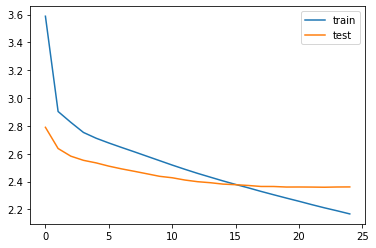

In [39]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Let's save the model

In [40]:
model.save('../models/model.h5')

Here is the fun part of generating predictions
 - We need to reverse map the indices to the words
 - map the words to indices from the summaries tokenizer 

In [41]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

Then we define the encoder and decoder inference models to start making predictions.
 - The encoder inference model accepts text and returns the output generated from the 3 LSTMs and the hidden states and cell states. 
 - The decoder inference model accepts the start of the sequence identifier (in our case this is sostok) and predicts the next word until we have a complete summary. 

In [42]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_plot_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

Then we create the function that accepts the input text and outputs a predicted summary. 
 - It starts with sostok and will continue generating words until eostok is seen or the max summary length is reached.
 - It will predict the upcoming word from a given word by choosing the word with the max probability, and then updates the internal state of the decoder.

In [43]:
def decode_sequence(input_seq):

    # Encode the input as vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: 
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_overview_len - 1:
            stop_condition = True

        # Update the target sequence
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

Let's prepare our df_10_plots to be passed to our new function

In [167]:
df_10_plots = np.array(df_10['Plot'])

In [168]:
df_10_plots_seq = x_tokenizer.texts_to_sequences(df_10_plots)

In [169]:
df_10_plots = pad_sequences(df_10_plots_seq,  maxlen=max_plot_len, padding='post')

Let's see how this does with some of our 10 movies

In [174]:
for i in range(0, 4):
    print ('Title:', df_10.iloc[i]['Title'])
    print ('\nOriginal summary:', df_10.iloc[i]['Overview'])
    print ('\nPredicted summary:', decode_sequence(df_10_plots[i].reshape(1,
           max_plot_len)))
    print ('\n\n')

Title: The Basketball Diaries

Original summary: Film adaptation of street tough Jim Carroll's epistle about his kaleidoscopic free fall into the harrowing world of drug addiction.

Predicted summary:  start a young woman who is by the of the of his wife end



Title: Full of It

Original summary: A young kid (Pinkston) is forced to live out the lies he told to become popular.

Predicted summary:  start a young woman who is by the of the of his wife end



Title: Cradle Will Rock

Original summary: A true story of politics and art in the 1930s USA, centered around a leftist musical drama and attempts to stop its production.

Predicted summary:  start a young woman who is by the of the of his wife end



Title: True Blue

Original summary: The story of the year the Oxford and Cambridge boat race changed from a gentleman's race to one where winning was everything.

Predicted summary:  start a young woman who is by the of the of his wife end





Obviously the output isn't anything we would be satisfied with. However, this was meant as a learning tutorial and walkthrough of setting up a seq2seq RNN. Given our small dataset, we were never going to be able to learn something as complex as the English language. However, even if we did not have computational constraints and had a big enough dataset, we would still run into the problem of length. It is well known that LSTM seq2seq RNNs alone start to perform very poorly after about 30 or 40 words. This brings us to our next topic, "Attention".

"Attention" is simply the idea of freeing the encoder-decoder from the fixed-length internal representation. How is this accomplished?
 - In a simple encoder-decoder architecture the decoder starts making predictions by looking only at the final output of the encoder step.
 - With "attention", we build an architecture that attends every hidden state from each encoder node at every time step and then makes predictions. It learns which hidden encoder states to attend to and by how much. 

<a id = '4.2'></a>
<h3 style = "font-family:garamond; font-size:30px; background-color: white; color : royalblue; border-radius: 100px 100px; text-align:left">Transformers Library (pre-trained)</h3>

- Now we get to transformers, what arguably changed NLP completely.The biggest benefit comes from how the transformer lends itself to parallelization. Unlike RNNs, transformers do not require the sequential data to be processed in order. This, among other things, drastically reduces training times. 
- We will look at 2 implementations of transformers from the hugginngface's transformers library, T5 and Bart. Each is a pre-trained model with its own architecture and weights. 

<a id = '4.2'></a>
<h3 style = "font-family:garamond; font-size:30px; background-color: white; color : royalblue; border-radius: 100px 100px; text-align:left">T5</h3>

 - T5 is pre-trained on a multi-task mixture of unsupervised and supervised tasks and for which each task is conveted into a text-to-text format. 
 - It uses relative scalar embeddings and encoder input padding can be done on the left and the right.

In [210]:
import torch
import json 
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

We simply choose from one of the pre-trained models to tokenize with. In our case we went with t5-base, but there are smaller and larger ones to choose from.

In [215]:
T5model = T5ForConditionalGeneration.from_pretrained('t5-base')
T5tokenizer = T5Tokenizer.from_pretrained('t5-base')

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

In [222]:
processed_text = single_samp.iloc[0]['Plot'].strip().replace("\n","")

 - Then we simply encode the inputs and pass that to T5model.generate(), setting the desired parameters. 

In [223]:
tokens_input = T5tokenizer.encode(Preprocessed_text,return_tensors="pt", max_length=512, truncation=True)
summary_ids = T5model.generate(tokens_input, 
                               min_length=40, 
                               max_length=400, 
                               num_beams=4, 
                               no_repeat_ngram_size=2, 
                               early_stopping=True)
summary = T5tokenizer.decode(summary_ids[0])
print(summary)

<pad> the film follows the tiny Tom Thumb as he is abducted from his loving parents. he is taken to an experimental laboratory and his subsequent escape. the film is largely dialogue-free, limited mostly to grunts and other non-verbal vocalizations.</s>


Now let's make overviews for our 10 movies

In [228]:
T5_generated_overview = []
for i in df_10.Plot:
    t5_prepared_Text = "summarize: "+ i
    tokenized_text = T5tokenizer.encode(t5_prepared_Text, return_tensors="pt")
    summary_ids = T5model.generate(tokenized_text,
                                num_beams=4,
                                no_repeat_ngram_size=2,
                                min_length=40,
                                max_length=400,
                                early_stopping=True)

    output = T5tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    T5_generated_overview.append(output)

In [229]:
T5_generated_overview

["the film is an adaptation of poet and memoirist Jim Carroll's juvenile diaries. the role of Jim is played by Leonardo DiCaprio and is based on his life in the u.s.",
 'a new kid at bridgeport high school lies to get the other kids to like him. he breaks the mirror behind his door after an argument with his parents, and breaks it again the next day.',
 "the federal theatre project is under increasing pressure from the u.s. government. federal government is investigating alleged leftist infiltration of american society, says sanjay gupta. the show's director and producer set up an improvised performance in a shuttered theater, with Blitzstein as both the cast and the orchestra.",
 'low-budget film tells the story of the 1987 Oxford Cambridge Boat Race. the crew lost by almost seven lengths to the competition in oxford, scotland, on thursday, february 6 - the first time ever a crew has been filmed in the u.s. true blue was directed by Ferdinand Fairfax and starring domin west and jason 

<a id = '4.3'></a>
<h3 style = "font-family:garamond; font-size:30px; background-color: white; color : royalblue; border-radius: 100px 100px; text-align:left">BART</h3>

 - At this time of this writing, BART reigns as king of text summarization.
 - BART is a denoising autoencoder for pre-training seq2seq models.
 - It uses both BERT (bidirectional encoder) and GPT (left to the right decoder) architecture. 
 - As described by huggingface, BART is trained by:
     - (1) corrupting text with an arbitrary noising function, and 
     - (2) learning a model to reconstruct the original text. 
 - BART does well on many tasks like abstractive dialogue, question answering and summarization.
 - It is trained on the CNN/Daily Mail data set
 

In [203]:
from transformers import pipeline
import os

'''os.environ["CUDA_VISIBLE_DEVICES"] = "0"'''

'os.environ["CUDA_VISIBLE_DEVICES"] = "0"'

Instantiate the pipeline passing in the desired task. We can also pass in a specific model, otherwise it defaults to the sshleifer/distilbart-cnn-12-6 model. 

In [204]:
summarizer = pipeline("summarization")

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


We shall use single_sample_plot again. We simply pass in the text we want, along with the max and min length.  

In [206]:
summary_text = summarizer(single_samp.iloc[0]['Plot'], max_length=120, min_length=15, do_sample=False)[0]['summary_text']

Your max_length is set to 120, but you input_length is only 77. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


In [207]:
print("\n\nPytorch Bart Overview: ", summary_text)



Pytorch Bart Overview:   The story follows the tiny Tom Thumb as he is abducted from his loving parents and taken to an experimental laboratory . He discovers a community of similarly-sized people living in a swamp . The film is largely dialogue-free, limited mostly to grunts and other non-verbal vocalizations .


In [208]:
bart_generated_overview = []
for i in df_10['Plot']:
    summarizer = pipeline('summarization')
    summary_text = summarizer(i, max_length=120, min_length=15, do_sample=False)[0]['summary_text']
    bart_generated_overview.append(summary_text)

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
Your max_length is set to 120, b

<a id = '5'></a>
<h1 style = "font-family: garamond; font-size: 35px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :royalblue; border-radius: 100px 100px; text-align:left " >Results</h1>

<a id = '5.1'></a>
<h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :royalblue; border-radius: 100px 100px; text-align:left " >Subjective measures</h1>

In [238]:
df_10_all = df_10[['Title', 'Plot', 'Overview']]
df_10_all['spacy_overview'] = spacy_generated_overview
df_10_all['lsa_overview'] = sumy_lsa_generated_overview
df_10_all['luhn_overview'] = sumy_luhn_generated_overview
df_10_all['T5_overview'] = T5_generated_overview
df_10_all['bart_overview'] = bart_generated_overview

C:\Users\rotzn\AppData\Local\Temp/ipykernel_18768/2248086320.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_10_all['spacy_overview'] = spacy_generated_overview
C:\Users\rotzn\AppData\Local\Temp/ipykernel_18768/2248086320.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_10_all['lsa_overview'] = sumy_lsa_generated_overview


In [239]:
df_10_all

,Title,Plot,Overview,spacy_overview,lsa_overview,luhn_overview,T5_overview,bart_overview
0,The Basketball Diaries,The film is an adaptation of poet and memoiris...,Film adaptation of street tough Jim Carroll's ...,"Bobby (Michael Imperioli), a best friend who i...","Bobby (Michael Imperioli), a best friend who i...",As a member of a seemingly unbeatable high sch...,the film is an adaptation of poet and memoiris...,The film is an adaptation of poet and memoiri...
1,Full of It,Sam Leonard is the new kid at Bridgeport High ...,A young kid (Pinkston) is forced to live out t...,"Sam tells lies like ""I drive a Porsche"", ""My d...",Sam Leonard is the new kid at Bridgeport High ...,Sam Leonard is the new kid at Bridgeport High ...,a new kid at bridgeport high school lies to ge...,Sam Leonard is the new kid at Bridgeport High...
2,Cradle Will Rock,"At the height of the Great Depression, aspirin...",A true story of politics and art in the 1930s ...,"The WPA, faced with the threat of losing its b...",Playwright Marc Blitzstein is working on his n...,Playwright Marc Blitzstein is working on his n...,the federal theatre project is under increasin...,"At the height of the Great Depression, aspiri..."
3,True Blue,True Blue is a film adaptation of Topolski's b...,The story of the year the Oxford and Cambridge...,We then see a montage of training sequences be...,The film opens with a fancied Oxford crew losi...,"Although names and events were changed, it tel...",low-budget film tells the story of the 1987 Ox...,"Directed by Ferdinand Fairfax, this low-budge..."
4,Gimme an 'F',The plot centers on a competition between high...,Can a squad of misfit cheerleaders with an ove...,The competition takes place at a camp run by m...,The competition takes place at a camp run by m...,The competition takes place at a camp run by m...,the plot centers on a competition between high...,The plot centers on a competition between hig...
5,Brooklyn Rules,"In 1985 Michael (Freddie Prinze Jr.), the narr...","Brooklyn, 1985. With the mob world as a backdr...","As their relationship blossoms, leaving the st...","In 1985 Michael (Freddie Prinze Jr.), the narr...","In 1985 Michael (Freddie Prinze Jr.), the narr...","in 1985, a con man scams his way into the pre-...",In 1985 Michael (Freddie Prinze Jr.) is a lov...
6,King Kong Lives,"King Kong, after being shot down from the Worl...",Kong falls from the twin towers and he appears...,"After being followed, attacked, and shot by th...","However, he has lost so much blood that a tran...","King Kong, after being shot down from the Worl...",king Kong is kept alive in a coma for about 10...,King Kong is kept alive in a coma for about 1...
7,Mr. Jones,Mr. Jones (Richard Gere) is a man suffering fr...,The story about the relationship between a man...,Mr. Jones (Richard Gere) is a man suffering fr...,Mr. Jones (Richard Gere) is a man suffering fr...,Mr. Jones (Richard Gere) is a man suffering fr...,a man suffering from bipolar disorder jumps up...,Mr. Jones (Richard Gere) is a man suffering f...
8,Hanging Up,"Georgia Mozell, Eve Marks and Maddy Mozell are...",A trio of sisters bond over their ambivalence ...,Despite being as busy with her own life as the...,Georgia (Keaton) is the editor of her own wild...,"Georgia Mozell, Eve Marks and Maddy Mozell are...",Georgia (Keaton) is the editor of her own wild...,"Georgia Mozell, Eve Marks and Maddy Mozell ar..."
9,Black Butterfly,The story of Black Butterfly focuses on how ce...,A Peruvian schoolteacher conspires with a jour...,"Mithun Murali, Malavika Sai, Niranj Kumar, and...",The story of Black Butterfly focuses on how ce...,The story of Black Butterfly focuses on how ce...,the film portrays the theme of romantic love b...,The story of Black Butterfly focuses on how c...


In [231]:
print('Title: ', df_10.iloc[0]['Title'],
      '\n\nLegit Overview: ',  df_10.iloc[0]["Overview"],
      "\n\nspacy Overview: ", spacy_generated_overview[0],
      "\n\nLSA overview: ", sumy_lsa_generated_overview[0],
      "\n\nluhn overview: ", sumy_luhn_generated_overview[0],
      "\n\nT5 overview: ", T5_generated_overview[0],
      "\n\nbart overview: ", bart_generated_overview[0]
     )


Title:  The Basketball Diaries 

Legit Overview:  Film adaptation of street tough Jim Carroll's epistle about his kaleidoscopic free fall into the harrowing world of drug addiction. 

spacy Overview:  Bobby (Michael Imperioli), a best friend who is dying of leukemia; a coach ("Swifty", played by Bruno Kirby) who makes sexual advances to Jim; and an appetite for cocaine and heroin begin to encroach on young Jim's dream of becoming a basketball star. As a member of a seemingly unbeatable high school basketball squad, Jim's life centers on his friends and the basketball court; the court becomes a metaphor for the world in his mind. The film is an adaptation of poet and memoirist Jim Carroll's juvenile diaries chronicling his kaleidoscopic free-fall into the harrowing world of drug addiction. 

LSA overview:  Bobby (Michael Imperioli), a best friend who is dying of leukemia; a coach ("Swifty", played by Bruno Kirby) who makes sexual advances to Jim; and an appetite for cocaine and heroin b

<a id = '5.2'></a>
<h1 style = "font-family: garamond; font-size: 35px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :royalblue; border-radius: 100px 100px; text-align:left " >5.2 Objective measures</h1>

<h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :royalblue; border-radius: 100px 100px; text-align:left " >Cosine Similarity</h1>

Cosine similarity is a metric that measures how similar two documents are regardless of their size. It measures the cosine of the angle between two vectors projected in a multi-dimensional space. It is advantageous because even if the two documents are far apart in their Euclidean distance (because of the difference in document sizes), they may still be oriented close together. Thus, a smaller angle means a higher cosine similarity. 

In [240]:
df_10_scores = df_10[['Title']]

We will use a pre-trained word vector

In [259]:
from gensim.scripts.glove2word2vec import glove2word2vec
import scipy

In [246]:
path = "../global_vectors_for_word_rep/glove.6B.200d.txt"
final = glove2word2vec(path ,"./glove.6B.200d.txt")

C:\Users\rotzn\AppData\Local\Temp/ipykernel_18768/2554914634.py:2: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  final = glove2word2vec(path ,"./glove.6B.200d.txt")


In [247]:
glove = gensim.models.KeyedVectors.load_word2vec_format("./glove.6B.200d.txt")

In [248]:
def cosine_distance_wordembedding_method(sent1, sent2):
    vector_1 = np.mean([glove[word] for word in sent1 if word in glove],axis=0)
    vector_2 = np.mean([glove[word] for word in sent2 if word in glove],axis=0)
    cosine = scipy.spatial.distance.cosine(vector_1, vector_2)
    return 1-cosine

In [257]:
def get_cosine(dataframe, over_col, gen_over_col):
    overview_tokens = dataframe[over_col].apply(lambda x: x.split(" "))
    gen_overview_tokens = dataframe[gen_over_col].apply(lambda x: x.split(" "))
    df_tokens = pd.DataFrame()
    df_tokens['over_tokens'] = overview_tokens
    df_tokens['gen_tokens'] = gen_overview_tokens
    scores = df_tokens.apply(lambda x: cosine_distance_wordembedding_method(x.gen_tokens, x.over_tokens), axis=1)
    return scores   

In [264]:
my_list = ['spacy_overview', 'lsa_overview', 'luhn_overview', 'T5_overview', 'bart_overview']
for item in my_list:
    df_10_scores[item] = get_cosine(df_10_all, 'Overview', item)

0    [Bobby, (Michael, Imperioli),, a, best, friend...
1    [Sam, tells, lies, like, "I, drive, a, Porsche...
2    [The, WPA,, faced, with, the, threat, of, losi...
3    [We, then, see, a, montage, of, training, sequ...
4    [The, competition, takes, place, at, a, camp, ...
5    [As, their, relationship, blossoms,, leaving, ...
6    [After, being, followed,, attacked,, and, shot...
7    [Mr., Jones, (Richard, Gere), is, a, man, suff...
8    [Despite, being, as, busy, with, her, own, lif...
9    [Mithun, Murali,, Malavika, Sai,, Niranj, Kuma...
Name: gen_tokens, dtype: object
0    [Bobby, (Michael, Imperioli),, a, best, friend...
1    [Sam, Leonard, is, the, new, kid, at, Bridgepo...
2    [Playwright, Marc, Blitzstein, is, working, on...
3    [The, film, opens, with, a, fancied, Oxford, c...
4    [The, competition, takes, place, at, a, camp, ...
5    [In, 1985, Michael, (Freddie, Prinze, Jr.),, t...
6    [However,, he, has, lost, so, much, blood, tha...
7    [Mr., Jones, (Richard, Gere)

C:\Users\rotzn\AppData\Local\Temp/ipykernel_18768/4216864679.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_10_scores[item] = get_cosine(df_10_all, 'Overview', item)


In [453]:
df_10_scores

,Title,spacy_overview,lsa_overview,luhn_overview,T5_overview,bart_overview
0,The Basketball Diaries,0.930062,0.912673,0.916684,0.903839,0.932502
1,Full of It,0.932122,0.952310,0.952310,0.949195,0.959971
2,Cradle Will Rock,0.930729,0.942633,0.935787,0.927647,0.935730
3,True Blue,0.961916,0.951214,0.956638,0.953571,0.949985
4,Gimme an 'F',0.887401,0.875499,0.878271,0.902013,0.893063
5,Brooklyn Rules,0.945402,0.946662,0.946662,0.923265,0.925682
6,King Kong Lives,0.938101,0.937681,0.940058,0.930097,0.911674
7,Mr. Jones,0.960564,0.960564,0.960564,0.942927,0.960088
8,Hanging Up,0.958232,0.943763,0.955363,0.931923,0.947105
9,Black Butterfly,0.863607,0.860343,0.860343,0.807854,0.841868


Text(0.125, -0.16, ' We can see that the extractive methods actually did better with cosine similarity. They had better means and \n less variabilty. However, our sample size is very small. Additionally, cosine similarity is a very basic way to \n evaluate how similar two different pieces of text are. Nowadays, ROUGE score is the prefered text summarization \n evaluation metric. ')

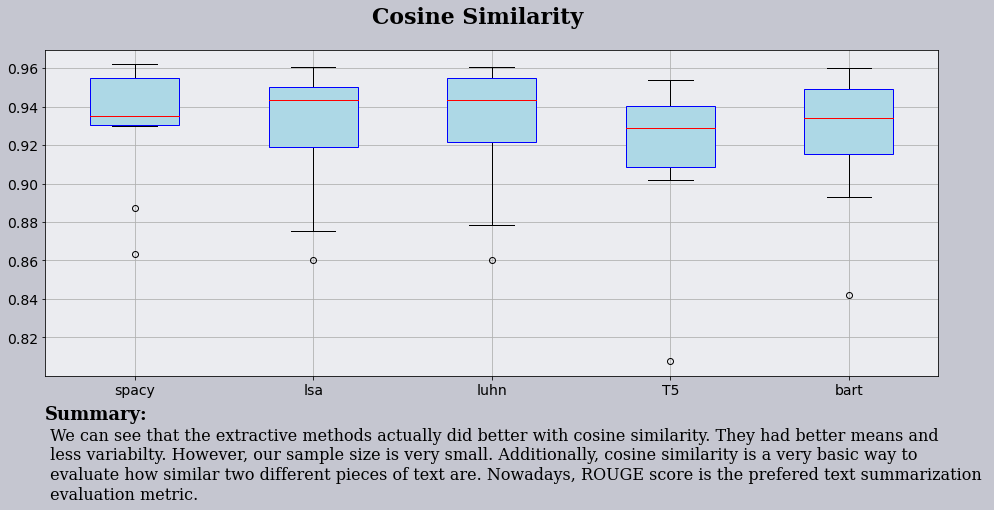

In [551]:
cosine_dict = {'spacy': list(df_10_scores.spacy_overview),
              'lsa': list(df_10_scores.lsa_overview),
              'luhn': list(df_10_scores.luhn_overview),
              'T5': list(df_10_scores.T5_overview),
              'bart': list(df_10_scores.bart_overview)}

font_1 = {'font': 'Serif','weight':'bold','size': '16','style':'normal', 'color':'#fc0fc0'}
ax_background_color = '#ebecf0'
titles_font = {'font': 'Serif', 'size': '18','weight':'bold', 'color':'black'}
fig_background_color = '#c5c6d0'

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))
fig.suptitle('Cosine Similarity', font = 'Serif', weight='bold', color='black', size=22)
fig.patch.set_facecolor(fig_background_color)


ax.boxplot(cosine_dict.values(), patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), medianprops=dict(color='red'))
ax.set_xticklabels(cosine_dict.keys())
ax.set_facecolor(ax_background_color)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=14)

fig.text(0.125, 0.025, 'Summary:',
         {'font':'Serif', 'size':18,'weight':'bold' ,'color':'black'})
fig.text(0.125, -0.16, " We can see that the extractive methods actually did better with cosine similarity. They had better means and \n less variabilty. However, our sample size is very small. Additionally, cosine similarity is a very basic way to \n evaluate how similar two different pieces of text are. Nowadays, ROUGE score is the prefered text summarization \n evaluation metric. ",
         {'font':'Serif', 'size':16,'weight':'normal' ,'color':'black'})



<h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :royalblue; border-radius: 100px 100px; text-align:left " >ROUGE Score</h1>

In [273]:
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [274]:
from rouge import Rouge

 -  What is ROUGE score? ROUGE is actually a set of metrics. ROUGE is comprised of a ROUGE-N (ROUGE-1, ROUGE-2, etc.), ROUGE-L and sometimes ROUGE-S (not covered here), each of which has a recall, precision and F1 score.
 -  ROUGE-N: Measures the number of matching 'n-grams' between generated text and the reference text. Thus ROUGE-1 measures the matching number of unigrams (1 token/word). ROUGE-2 measures the matching number of bigrams (2 consecutive tokens/words).
     - Recall: counts the number of overlapping n-grams found in both the model output and reference divided by the total number of n-grams in the reference. This ensures our model is getting all the information in the reference, but does NOT ensure our model isn't just producing a large number of words to improve the recall score.
     - Precision: counts the number of overlapping n-grams found in the model output and reference, and then divides this by the model n-gram count (rather than the reference n-gram count). It essentially measures how much of the output of the machine generated summary was in fact relevant or needed. This helps us to avoid the problem with recall mentioned above. Thus, precision is crucial when you are trying to generate summaries that are concise rather than verbose. 
     - F1: The best of both worlds, F1 is 2 * ((precision * recall) / (precision + recall)). This gives us a nice balance between precision and recall.
 - ROUGE-L: measures the LCS (longest common sequence) between the model output and the reference. In other words, we count the longest sequence of tokens that is shared between them. Essentially the idea is a longer shared sequence indicates more similarity. Recall, Precision and F1 are used just as before but instead of matched n-grams we use LCS as the numerator.

In [267]:
df_10_all.head(2)

,Title,Plot,Overview,spacy_overview,lsa_overview,luhn_overview,T5_overview,bart_overview
0,The Basketball Diaries,The film is an adaptation of poet and memoiris...,Film adaptation of street tough Jim Carroll's ...,"Bobby (Michael Imperioli), a best friend who i...","Bobby (Michael Imperioli), a best friend who i...",As a member of a seemingly unbeatable high sch...,the film is an adaptation of poet and memoiris...,The film is an adaptation of poet and memoiri...
1,Full of It,Sam Leonard is the new kid at Bridgeport High ...,A young kid (Pinkston) is forced to live out t...,"Sam tells lies like ""I drive a Porsche"", ""My d...",Sam Leonard is the new kid at Bridgeport High ...,Sam Leonard is the new kid at Bridgeport High ...,a new kid at bridgeport high school lies to ge...,Sam Leonard is the new kid at Bridgeport High...


In [283]:
rouge = Rouge()
spacy_rouge = rouge.get_scores(df_10_all['spacy_overview'], df_10_all.Overview, avg=True)
lsa_rouge = rouge.get_scores(df_10_all['lsa_overview'], df_10_all.Overview, avg=True)
luhn_rouge = rouge.get_scores(df_10_all['luhn_overview'], df_10_all.Overview, avg=True)
T5_rouge = rouge.get_scores(df_10_all['T5_overview'], df_10_all.Overview, avg=True)
bart_rouge = rouge.get_scores(df_10_all['bart_overview'], df_10_all.Overview, avg=True)

Maybe we just get F1 score for each? 

In [358]:
rouge_1_scores = pd.DataFrame()
rouge_2_scores = pd.DataFrame()
rouge_L_scores = pd.DataFrame()

In [350]:
def extract_scores(dictionary, rouge):
    return pd.Series(data=dictionary[rouge], index=['r','p','f']).rename(index={'r': 'recall', 'p':'precision','f':'f1'})

In [359]:
scores_list = [spacy_rouge, lsa_rouge, luhn_rouge, T5_rouge, bart_rouge]
names = ['spacy', 'lsa', 'luhn', 'T5', 'bart']

for i in range(len(scores_list)):
    temp = extract_scores(scores_list[i], 'rouge-1', ).rename(names[i])
    rouge_1_scores = rouge_1_scores.append(temp)
    
for i in range(len(scores_list)):
    temp = extract_scores(scores_list[i], 'rouge-2', ).rename(names[i])
    rouge_2_scores = rouge_2_scores.append(temp)

for i in range(len(scores_list)):
    temp = extract_scores(scores_list[i], 'rouge-l', ).rename(names[i])
    rouge_L_scores = rouge_L_scores.append(temp)

Text(0.125, -0.055, "We can see here that none of the models really stood out when it comes to recall. This demonstrats that most of our models \n are actually retaining quite a bit of the information from the reference, but does not ensure that the model isn't just repeating \n words. This is why precision and recall are better measures of summarization. With precision and f1, we can see the Bart \n model is the clear winner. This is not surprising, as it is currently considered the best text summarizing model. The high \n precision score and f1 score indicates that it produces an output that is concise rather than verbose.  ")

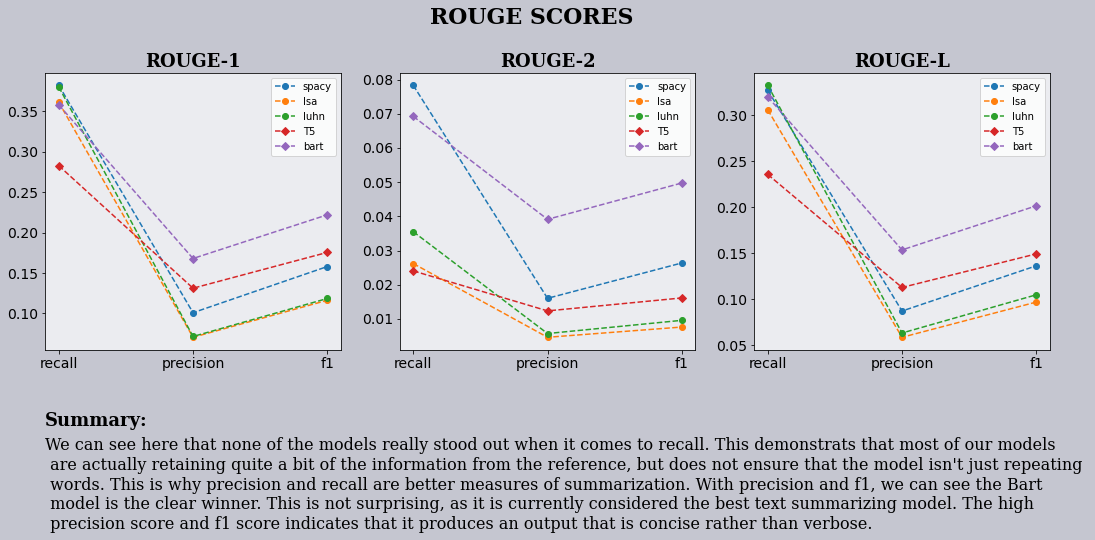

In [449]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 7))
fig.suptitle('ROUGE SCORES', font = 'Serif', weight='bold', color='black', size=22)
fig.patch.set_facecolor(fig_background_color)

# ROUGE-1
ax[0].set_title('ROUGE-1', titles_font)
ax[0].set_position([0.125, 0.3, 0.22794117647058826, 0.55])
ax[0].plot(rouge_1_scores.iloc[0], label = rouge_1_scores.iloc[0].name, linestyle='--', marker='o' )
ax[0].plot(rouge_1_scores.iloc[1], label = rouge_1_scores.iloc[1].name, linestyle='--', marker='o' )
ax[0].plot(rouge_1_scores.iloc[2], label = rouge_1_scores.iloc[2].name, linestyle='--', marker='o' )
ax[0].plot(rouge_1_scores.iloc[3], label = rouge_1_scores.iloc[3].name, linestyle='--', marker='D' )
ax[0].plot(rouge_1_scores.iloc[4], label = rouge_1_scores.iloc[4].name, linestyle='--', marker='D' )
ax[0].set_facecolor(ax_background_color)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].legend()

# ROUGE-2
ax[1].set_title('ROUGE-2', titles_font)
ax[1].set_position([0.3985294117647059, 0.3, 0.2279411764705882, 0.55])
ax[1].plot(rouge_2_scores.iloc[0], label = rouge_2_scores.iloc[0].name, linestyle='--', marker='o' )
ax[1].plot(rouge_2_scores.iloc[1], label = rouge_2_scores.iloc[1].name, linestyle='--', marker='o' )
ax[1].plot(rouge_2_scores.iloc[2], label = rouge_2_scores.iloc[2].name, linestyle='--', marker='o' )
ax[1].plot(rouge_2_scores.iloc[3], label = rouge_2_scores.iloc[3].name, linestyle='--', marker='D' )
ax[1].plot(rouge_2_scores.iloc[4], label = rouge_2_scores.iloc[4].name, linestyle='--', marker='D' )
ax[1].set_facecolor(ax_background_color)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].legend()

# ROUGE-L
ax[2].set_title('ROUGE-L', titles_font)
ax[2].set_position([0.6720588235294118, 0.3, 0.2279411764705883, 0.55])
ax[2].plot(rouge_L_scores.iloc[0], label = rouge_L_scores.iloc[0].name, linestyle='--', marker='o' )
ax[2].plot(rouge_L_scores.iloc[1], label = rouge_L_scores.iloc[1].name, linestyle='--', marker='o' )
ax[2].plot(rouge_L_scores.iloc[2], label = rouge_L_scores.iloc[2].name, linestyle='--', marker='o' )
ax[2].plot(rouge_L_scores.iloc[3], label = rouge_L_scores.iloc[3].name, linestyle='--', marker='D' )
ax[2].plot(rouge_L_scores.iloc[4], label = rouge_L_scores.iloc[4].name, linestyle='--', marker='D' )
ax[2].set_facecolor(ax_background_color)
ax[2].tick_params(axis='both', which='major', labelsize=14)
ax[2].legend()


fig.text(0.125, 0.15, 'Summary:',
         {'font':'Serif', 'size':18,'weight':'bold' ,'color':'black'})
fig.text(0.125, -0.055, "We can see here that none of the models really stood out when it comes to recall. This demonstrats that most of our models \n are actually retaining quite a bit of the information from the reference, but does not ensure that the model isn't just repeating \n words. This is why precision and recall are better measures of summarization. With precision and f1, we can see the Bart \n model is the clear winner. This is not surprising, as it is currently considered the best text summarizing model. The high \n precision score and f1 score indicates that it produces an output that is concise rather than verbose.  ",
         {'font':'Serif', 'size':16,'weight':'normal' ,'color':'black'})

<a id = '6'></a>
<h1 style = "font-family: garamond; font-size: 45px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :royalblue; border-radius: 100px 100px; text-align:center " >Summary</h1>

# rewrite below

As we can see, the extractive approach scores better on cosine similarity and on the rouge scores. This is to be expected because the extractive approach literally lifts full sentences from the original text. The real test is the human subjective test, and on that the winner goes to the abstractive method. I think the vast majority of people would agree with this. With the extractive approach, the sentences feel out of place or inserted at random and they do not flow together. With the abstractive approach, there is a flow to the sentences, even if the content sometimes doesn't make sense. I think for the average review, one would glean a more accurate summarization of the movie from the abstractive approach.